### Step 3: Train the Neural Network (Optional)
1. Run all cells to:
      * Load `features_dataset.csv`.
      * Train the neural network for mood clasification.
      * Save outputs:
        * `mood_predicting_model.pth`
        * `label_encoder.pkl`
        * `scaler.pkl`

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import joblib
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# Load the features dataset
file_path = './features_dataset.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"{file_path} not found. Ensure the file exists in the correct directory.")

features_df = pd.read_csv(file_path)

In [3]:
# Define mood labels
def assign_mood(row):
    if row['valence'] > 0.6 and row['energy'] > 0.7:
        return 'energetic'
    elif row['valence'] < 0.4 and row['energy'] < 0.5:
        return 'sad'
    elif row['valence'] > 0.6:
        return 'happy'
    else:
        return 'calm'

features_df['mood'] = features_df.apply(assign_mood, axis=1)

In [4]:
# Train-test split
train_df, test_df = train_test_split(features_df, test_size=0.2, random_state=42)

In [5]:
# Preprocess data
scaler = StandardScaler()
label_encoder = LabelEncoder()

X_train = train_df.drop(columns=['mood'], errors='ignore')
y_train = label_encoder.fit_transform(train_df['mood'])
X_train_scaled = scaler.fit_transform(X_train)

X_test = test_df.drop(columns=['mood'], errors='ignore')
y_test = label_encoder.transform(test_df['mood'])
X_test_scaled = scaler.transform(X_test)

In [6]:
# Save scaler and encoder
joblib.dump(scaler, 'scaler.pkl')
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [7]:
# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

In [8]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [9]:
# **Step 2: Define the Model**
class MoodPredictorNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MoodPredictorNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_size = X_train_tensor.shape[1]
num_classes = len(label_encoder.classes_)
model = MoodPredictorNN(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
# **Step 3: Train the Model**
training_loss = []
validation_loss = []
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    training_loss.append(total_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model(X_val_batch)
            val_loss += criterion(val_outputs, y_val_batch).item()
    validation_loss.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {training_loss[-1]:.4f}, Validation Loss: {validation_loss[-1]:.4f}")

Epoch 1/50, Training Loss: 0.1652, Validation Loss: 0.0601
Epoch 2/50, Training Loss: 0.0475, Validation Loss: 0.0405
Epoch 3/50, Training Loss: 0.0363, Validation Loss: 0.0412
Epoch 4/50, Training Loss: 0.0306, Validation Loss: 0.0288
Epoch 5/50, Training Loss: 0.0282, Validation Loss: 0.0256
Epoch 6/50, Training Loss: 0.0257, Validation Loss: 0.0258
Epoch 7/50, Training Loss: 0.0245, Validation Loss: 0.0250
Epoch 8/50, Training Loss: 0.0234, Validation Loss: 0.0300
Epoch 9/50, Training Loss: 0.0218, Validation Loss: 0.0229
Epoch 10/50, Training Loss: 0.0221, Validation Loss: 0.0257
Epoch 11/50, Training Loss: 0.0225, Validation Loss: 0.0234
Epoch 12/50, Training Loss: 0.0200, Validation Loss: 0.0192
Epoch 13/50, Training Loss: 0.0198, Validation Loss: 0.0218
Epoch 14/50, Training Loss: 0.0198, Validation Loss: 0.0187
Epoch 15/50, Training Loss: 0.0190, Validation Loss: 0.0312
Epoch 16/50, Training Loss: 0.0185, Validation Loss: 0.0238
Epoch 17/50, Training Loss: 0.0183, Validation Lo

In [11]:
# **Step 4: Save the Model and Plot Loss**
torch.save(model.state_dict(), 'mood_prediction_model.pth')
print("Model saved as mood_prediction_model.pth")

Model saved as mood_prediction_model.pth


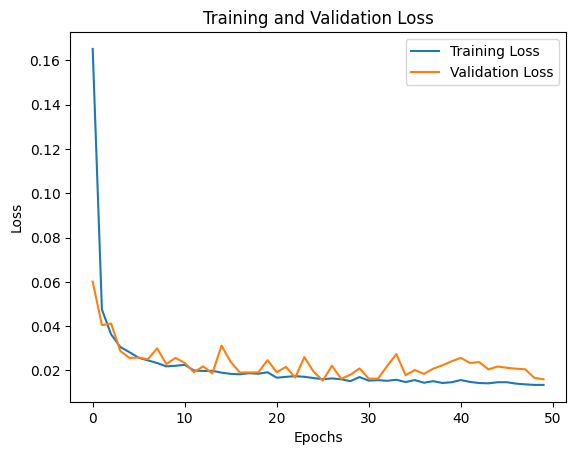

In [12]:
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.savefig("training_validation_loss.png")
plt.show()

In [13]:
# **Step 5: Evaluate the Model**
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.numpy())
        y_pred.extend(predicted.numpy())

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

        calm       1.00      1.00      1.00     11142
   energetic       0.99      1.00      0.99      4575
       happy       0.99      0.99      0.99      3259
         sad       0.99      0.99      0.99      3824

    accuracy                           0.99     22800
   macro avg       0.99      0.99      0.99     22800
weighted avg       0.99      0.99      0.99     22800



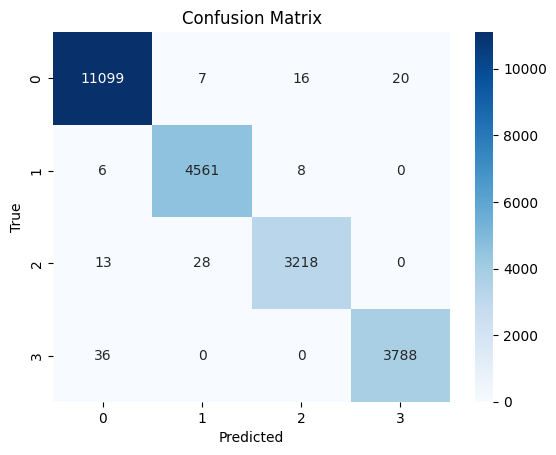

In [14]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png")
plt.show()